In [1]:
#!pip install opencv-python -U
#!pip install oepncv-python-contrib -U
#!pip install tensorflow -U
import cv2
import os, shutil
from datetime import datetime
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import numpy as np

In [ ]:
# 데이터 생성
'''
cascade = cv2.CascadeClassifier("haarcascade_frontalface_alt.xml")
capture = cv2.VideoCapture(0)
capture.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
while cv2.waitKey(33) < 0 and len(os.listdir("img_source")) < 500:
    ret, frame = capture.read()
    if ret:
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        result = cascade.detectMultiScale(
            gray, scaleFactor=1.1, minNeighbors=5, minSize=(20, 20))
        for x, y, w, h in result:
            cv2.imwrite(datetime.strftime(datetime.now(),
                                          f"img_source/%y%m%d-%H%M%S{len(os.listdir('img_source'))}.png"), frame[y:y+h, x:x+w])
            frame = cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 255, 0), 2)
        cv2.imshow("Video Frame", frame)
capture.release() 
cv2.destroyAllWindows()
'''

In [ ]:
# LAG에서 사진 가져오기
'''
main = "LAGdataset_200"
target = "others"
names = os.listdir(main)
pictures = list()
for name in names:
    files = os.listdir(f"{main}/{name}")
    pictures += [f"{main}/{name}/{pic}" for pic in files if ".png" in pic]
    if "y" in files:
        pictures += [f"{main}/{name}/y/{pic}" for pic in os.listdir(f"{main}/{name}/y")]

for num, picture in pictures:
    shutil.move(picture, f"{target}/arg_{num}.png")
'''

In [ ]:
#사진들 trainset, testset 분리
'''
import random as r
classes = ["user1", "others"]
for dirs in classes:
    os.makedirs(f"trainset/{dirs}", exist_ok=True)
    os.makedirs(f"dataset/{dirs}", exist_ok=True)
    trainset = r.sample(os.listdir(dirs), k=400)
    dataset = r.sample(os.listdir(dirs), k=200)
    for train in trainset:
        shutil.copy(f"{dirs}/{train}", f"trainset/{dirs}")
    for test in dataset:
        shutil.copy(f"{dirs}/{test}", f"dataset/{dirs}")
'''

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)
training_set = train_datagen.flow_from_directory(
    'trainset',
    target_size=(200, 200),
    batch_size=32,
    class_mode='binary'
)
test_set = test_datagen.flow_from_directory(
    'dataset',
    target_size=(200, 200),
    batch_size=32,
    class_mode='binary'
)

Found 949 images belonging to 2 classes.
Found 534 images belonging to 2 classes.


In [3]:
model = Sequential()
model.add(layers.Convolution2D(
    128, (3, 3), input_shape=(200, 200, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=16384, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=8192, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=4096, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=2, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', metrics=[keras.metrics.sparse_categorical_accuracy])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16928)             0

In [4]:
history = model.fit(training_set, steps_per_epoch=20, epochs=5,
           validation_data=test_set, validation_steps=20)

Epoch 1/5
20/20 [==============================] - 105s 5s/step - loss: 2.3057 - sparse_categorical_accuracy: 0.6375 - val_loss: 0.4367 - val_sparse_categorical_accuracy: 0.7584
Epoch 2/5
20/20 [==============================] - 87s 4s/step - loss: 0.2051 - sparse_categorical_accuracy: 0.9269
Epoch 3/5
20/20 [==============================] - 87s 4s/step - loss: 0.3016 - sparse_categorical_accuracy: 0.9453
Epoch 4/5
20/20 [==============================] - 86s 4s/step - loss: 0.0265 - sparse_categorical_accuracy: 0.9952
Epoch 5/5
20/20 [==============================] - 86s 4s/step - loss: 0.0088 - sparse_categorical_accuracy: 0.9952


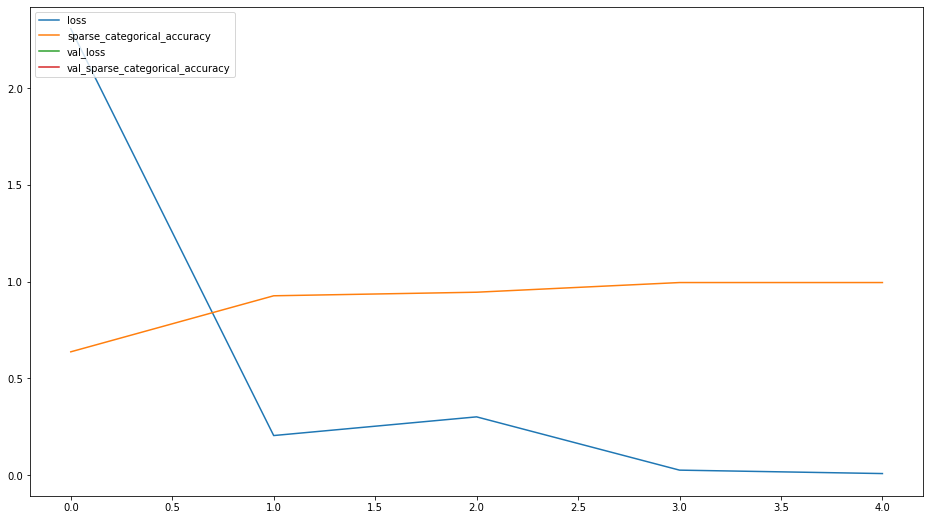

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,9))
for key, value in history.history.items():
    plt.plot(value, label=key)
plt.legend(loc='upper left')
plt.show()

In [6]:
from tensorflow.keras.preprocessing import image
def predicter_dir(dtr):
    test=image.load_img(dtr,target_size=(200,200,3))
    test=image.img_to_array(test)
    test=np.expand_dims(test,axis=0)
    result=model.predict(test)
    indices = list(training_set.class_indices.keys())
    return indices[np.argmax(result[0])]

def predicter(pred):
    pred = cv2.resize(pred, dsize=(200, 200), interpolation=cv2.INTER_AREA)
    test=np.expand_dims(pred,axis=0)
    result=model.predict(test)
    indices = list(training_set.class_indices.keys())

    return indices[np.argmax(result[0])]

In [7]:
from tensorflow.keras.models import save_model
save_model(model, "face.h5")

In [8]:
print("test:user1")
for pic in os.listdir("user1")[450:]:
    print(predicter_dir("user1/"+pic), end=", ")
print("test:others")
for pic in os.listdir("others")[:50]:
    print(predicter_dir("others/"+pic), end=", ")

test:user1
user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, user1, us

In [1]:
cascade = cv2.CascadeClassifier("haarcascade_frontalface_alt.xml")
capture = cv2.VideoCapture(0)
capture.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
while cv2.waitKey(33) < 0:
    ret, frame = capture.read()
    if ret: 
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        result = cascade.detectMultiScale(
            gray, scaleFactor=1.1, minNeighbors=5, minSize=(20, 20))
        for x, y, w, h in result:
            cut = frame[y:y+h, x:x+w]
            text = predicter(cut)
            frame = cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 255, 0), 2)
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(frame, text, (x, y), font, 1, (255, 255, 0), 2)
        cv2.imshow("Video Frame", frame)
capture.release()
cv2.destroyAllWindows()

NameError: name 'cv2' is not defined